# Noise Reduction and Image Optimization for Captcha Number Recognition



In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import pytesseract
from PIL import Image

In [2]:
def display_image(img, title):
    plt.imshow(img, cmap='gray')
    plt.axis('off')
    plt.title(title)


def read_captcha_image(path):
    img = cv2.imread(path)
    display_image(img, 'Original Captcha Image')
    return img


def to_grayscale(img):
    gray_image = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    display_image(gray_image, 'gray scale image')
    return gray_image


def median_filter(img):
    filtered_image = cv2.medianBlur(img, 3)
    display_image(filtered_image, 'filtered_image')
    return filtered_image


def mean_filter(img):
    filtered_image = cv2.filter2D(img, -1, np.ones((3, 3), dtype=np.float32) / (3**2))
    display_image(filtered_image, 'filtered_image')
    return filtered_image


def plot_hist(image):
    pixel_values = image.flatten()
    plt.figure(figsize=(8, 6))
    plt.hist(pixel_values, bins=256, range=[0, 256], color='gray', alpha=0.7)
    plt.title('Histogram of Grayscale Image')
    plt.xlabel('Pixel Intensity')
    plt.ylabel('Frequency')
    plt.grid(True)
    plt.show()


def get_threshold(filtered_image):
    histogram, bin_edges = np.histogram(filtered_image.flatten(), bins=256, range=(0, 256))
    mid_threshold = np.median(histogram)
    
    significant_ranges = []
    start, end = None, None
    for i, count in enumerate(histogram):
        if count > mid_threshold:
            if start is None:
                start = i
            end = i
        elif start is not None:
            significant_ranges.append((start, end))
            start, end = None, None
    
    if start is not None:
        significant_ranges.append((start, end))
    
    largest_range = max(significant_ranges, key=lambda x: x[1] - x[0])
    
    start_freq = histogram[largest_range[0]]
    end_freq = histogram[largest_range[1]]
    
    if start_freq <= 5:
        largest_range = (largest_range[0] + 1, largest_range[1])
    if end_freq <= 5:
        largest_range = (largest_range[0], largest_range[1] - 1)
    
    print(f"Largest Significant Range (Start, End): {largest_range}")
    print(f"Threshold (Mid Value): {(largest_range[1] + largest_range[0]) // 2}")

    plt.plot(histogram, color='gray')
    plt.axvline(largest_range[0], color='red', linestyle='--', label=f'Start: {largest_range[0]}')
    plt.axvline(largest_range[1], color='blue', linestyle='--', label=f'End: {largest_range[1]}')
    plt.title('Histogram with Largest Significant Range Highlighted')
    plt.xlabel('Pixel Intensity')
    plt.ylabel('Frequency')
    plt.legend()
    plt.grid(True)
    plt.show()
    return int((largest_range[1] + largest_range[0]) // 2)


def binary_image(threshold, filtered_image):
    binary_img = (filtered_image>=threshold).astype(int)*255
    display_image(binary_img, 'filtered_image')
    return binary_img

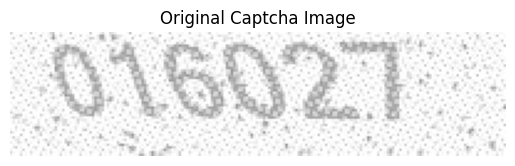

In [3]:
original_image = read_captcha_image('/kaggle/input/captcha-dataset/train-images/train-images/image_train_100.png')

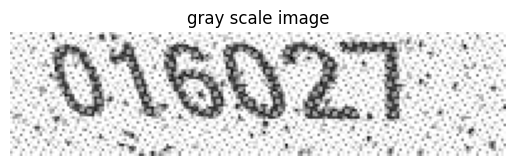

In [4]:
grayscale = to_grayscale(original_image)

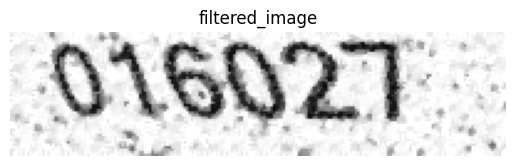

In [5]:
median_filtered = median_filter(grayscale)

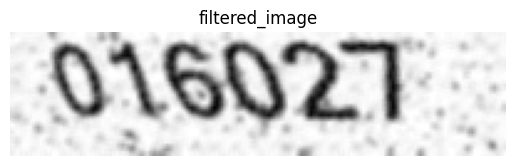

In [6]:
mean_filtered = mean_filter(median_filtered)

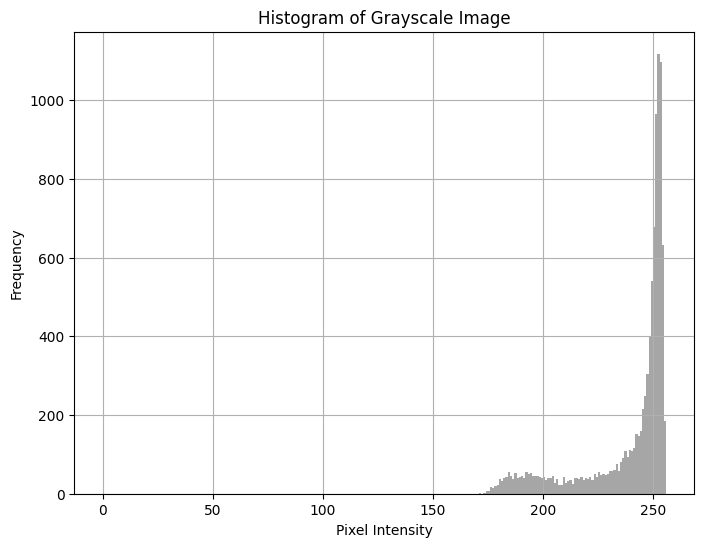

In [7]:
plot_hist(mean_filtered)

Largest Significant Range (Start, End): (174, 255)
Threshold (Mid Value): 214


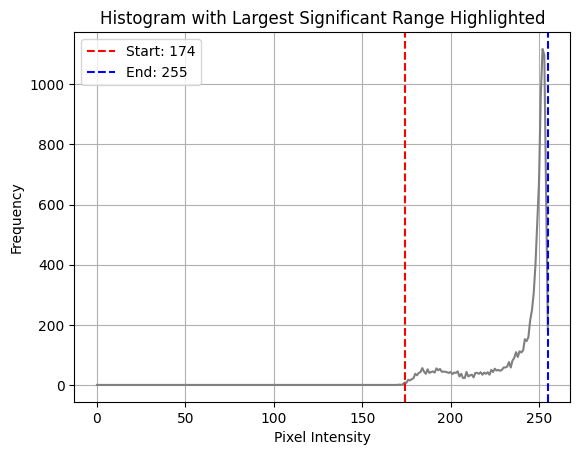

In [8]:
threshold = get_threshold(mean_filtered)

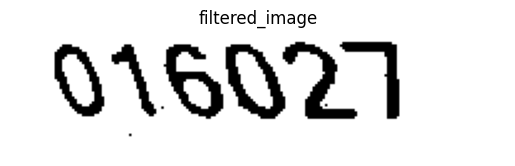

In [9]:
binary = binary_image(threshold, mean_filtered)

In [10]:
def calculate_threshold(filtered_image):
    histogram, bin_edges = np.histogram(filtered_image.flatten(), bins=256, range=(0, 256))
    mid_threshold = np.median(histogram)
    
    significant_ranges = []
    start, end = None, None
    for i, count in enumerate(histogram):
        if count > mid_threshold:
            if start is None:
                start = i
            end = i
        elif start is not None:
            significant_ranges.append((start, end))
            start, end = None, None
    
    if start is not None:
        significant_ranges.append((start, end))
    
    largest_range = max(significant_ranges, key=lambda x: x[1] - x[0])
    
    start_freq = histogram[largest_range[0]]
    end_freq = histogram[largest_range[1]]
    
    if start_freq <= 5:
        largest_range = (largest_range[0] + 1, largest_range[1])
    if end_freq <= 5:
        largest_range = (largest_range[0], largest_range[1] - 1)

    return int((largest_range[1] + largest_range[0]) // 2)

In [11]:
def process_image(path):
    img = cv2.imread(path)
    gray_image = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    filtered_image = cv2.medianBlur(gray_image, 3)
    filtered_image = cv2.filter2D(filtered_image, -1, np.ones((3, 3), dtype=np.float32) / (3**2))
    threshold = calculate_threshold(filtered_image)
    binary = binary_image(threshold, filtered_image)
    return binary

Processing and saving completed.


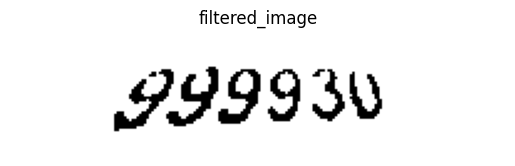

In [12]:
import os
import cv2
import numpy as np
import pandas as pd
from pathlib import Path

input_dir = '/kaggle/input/captcha-dataset/'
output_dir = '/kaggle/working/captcha_preprocess_data/'

captcha_data = pd.read_csv(os.path.join(input_dir, 'captcha_data.csv'))

os.makedirs(os.path.join(output_dir, 'train'), exist_ok=True)
os.makedirs(os.path.join(output_dir, 'test'), exist_ok=True)
os.makedirs(os.path.join(output_dir, 'validation'), exist_ok=True)

train_data = []
test_data = []
validation_data = []


for idx, row in captcha_data.iterrows():
    image_name = row['image_path']
    captcha_value = row['solution']
    
    if 'train' in image_name:
        folder = 'train'
        csv_data = train_data
    elif 'test' in image_name:
        folder = 'test'
        csv_data = test_data
    else:
        folder = 'validation'
        csv_data = validation_data
    
    image_path = os.path.join(input_dir, f'{folder}-images/{image_name}')
    
    binary = process_image(image_path)
    # plt.imshow(binary)
    
    if binary is None:
        continue 
    
    save_path = os.path.join(output_dir, folder, image_name)
    os.makedirs(os.path.dirname(save_path), exist_ok=True)
    success = cv2.imwrite(save_path, np.uint8(binary))

    if not success:
        print(f"Error saving image {save_path}")
        continue

    # pixel_values = binary.flatten().tolist()
    
    # csv_data.append({
    #     'image_path': image_name,
    #     'pixel_values': pixel_values,
    #     'captcha_value': captcha_value
    # })

# train_df = pd.DataFrame(train_data)
# test_df = pd.DataFrame(test_data)
# validation_df = pd.DataFrame(validation_data)

# train_df.to_csv(os.path.join(output_dir, 'train.csv'), index=False)
# test_df.to_csv(os.path.join(output_dir, 'test.csv'), index=False)
# validation_df.to_csv(os.path.join(output_dir, 'validation.csv'), index=False)

print("Processing and saving completed.")